In [40]:
import sys
sys.path.append('..')

In [41]:
ckpt = '2408/cifar10-ddpm-l1/12'
training_rootdir = '/group/jug/ashesh/training/diffsplit/'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2408/cifar10-ddpm-l1/12'

In [42]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [43]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

/group/jug/ashesh/training/diffsplit/2408/cifar10-ddpm-l1/12/checkpoint/I480000_E482


In [44]:
if 'patch_size' not in opt['datasets']:
    opt['datasets']['patch_size']  = opt['datasets']['train']['patch_size']

if 'max_qval' not in opt['datasets']:
    opt['datasets']['max_qval']  = 0.98

if 'uncorrelated_channels' not in opt['datasets']['train']:
    opt['datasets']['train']['uncorrelated_channels']  = False

In [45]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
from split import get_datasets
import os


# data
train_set, val_set = get_datasets(opt)

# model
diffusion = Model.create_model(opt)
diffusion.set_new_noise_schedule(opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

# load checkpoint
diffusion.load_network()

/group/jug/ashesh/data/cifar-10-python/train/data_batch_3
/group/jug/ashesh/data/cifar-10-python/train/data_batch_4
/group/jug/ashesh/data/cifar-10-python/train/data_batch_1
/group/jug/ashesh/data/cifar-10-python/train/data_batch_2
Computing mean and std for normalization
(6,)
[SplitDataset] Data: 3986x2x(3, 32, 32) Patch:32 Random:1 Aug:True Q:1.0 UpperClip:0Uncor:True
/group/jug/ashesh/data/cifar-10-python/val/data_batch_5
(6, 1, 1)
[SplitDataset] Data: 977x2x(3, 32, 32) Patch:32 Random:0 Aug:False Q:1.0 UpperClip:0Uncor:False


INFO:base:Initialization method [orthogonal]
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2408/cifar10-ddpm-l1/12/checkpoint/I480000_E482] ...
INFO:base:Network G structure: GaussianDiffusion, with parameters: 6,578,134
INFO:base:GaussianDiffusion(
  (denoise_fn): UNet(
    (time_mlp): Sequential(
      (0): TimeEmbedding()
      (1): Linear(in_features=16, out_features=64, bias=True)
      (2): Swish()
      (3): Linear(in_features=64, out_features=16, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (mlp): Sequential(
            (0): Swish()
            (1): Linear(in_features=16, out_features=16, bias=True)
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 16, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
             

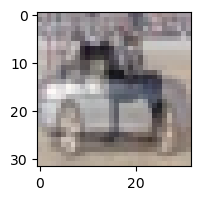

In [81]:
import numpy as np
import matplotlib.pyplot as plt
norm_dict = val_set.get_normalization_dict()

idx = np.random.randint(0,len(val_set))
data = val_set[idx]
inp = data['input']
target = data['target']
diffusion_data = {'input': torch.Tensor(inp)[None].cuda(), 'target': torch.Tensor(target[None]).cuda()}
inp = inp * norm_dict['std_input'] + norm_dict['mean_input']
inp = inp/np.max(inp)
_,ax = plt.subplots(figsize=(2,2))
plt.imshow(inp.transpose(1,2,0))

In [82]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')
diffusion.feed_data(diffusion_data)
diffusion.test(continous=True, clip_denoised=True)
visuals = diffusion.get_current_visuals()
# input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
input = visuals['input'].cpu().numpy()
target = visuals['target'].cpu().numpy()
prediction = visuals['prediction'].cpu().numpy()

# unnormalize 
pred_unnorm = prediction * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
target_unnorm = target * norm_dict['std_target'][None] + norm_dict['mean_target'][None]
input_unnorm = input * norm_dict['std_input'] + norm_dict['mean_input']

target_unnorm = target_unnorm.transpose(0,2,3,1)
pred_unnorm = pred_unnorm.transpose(0,2,3,1)
input_unnorm = input_unnorm.transpose(0,2,3,1)

if opt['datasets']['train']['name'] == 'cifar10':
    pred_unnorm = pred_unnorm.astype(np.uint8)
    target_unnorm = target_unnorm.astype(np.uint8)
    input_unnorm = input_unnorm.astype(np.uint16)



sampling loop time step: 100%|██████████| 2000/2000 [00:52<00:00, 37.94it/s]


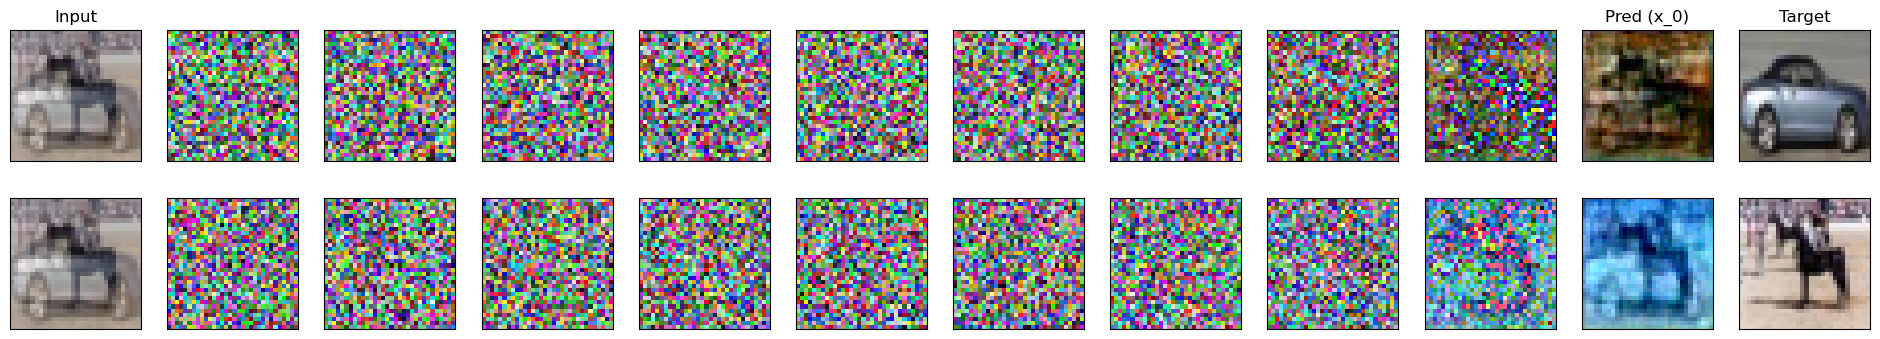

In [83]:
from disentangle.analysis.plot_utils import clean_ax
ncols = pred_unnorm.shape[0] + 1
nrows = 2
dfac = 1
rgb = target_unnorm.shape[-1]
_,ax = plt.subplots(figsize=(ncols*2,nrows*2), ncols=ncols, nrows=nrows)
for i in range(pred_unnorm.shape[0]):
    ax[0,i].imshow(pred_unnorm[i,::dfac,::dfac,:rgb//2])
    ax[1,i].imshow(pred_unnorm[i,::dfac,::dfac,rgb//2:])

ax[0,-1].imshow(target_unnorm[0,::dfac,::dfac,:rgb//2])
ax[1,-1].imshow(target_unnorm[0,::dfac,::dfac,rgb//2:])
ax[0,-1].set_title('Target')
ax[0,0].set_title('Input')
ax[0,-2].set_title('Pred (x_0)')
clean_ax(ax)

In [60]:
pred_unnorm[-1,...,2].max(), pred_unnorm[-1,...,2].min()

(255, 21)

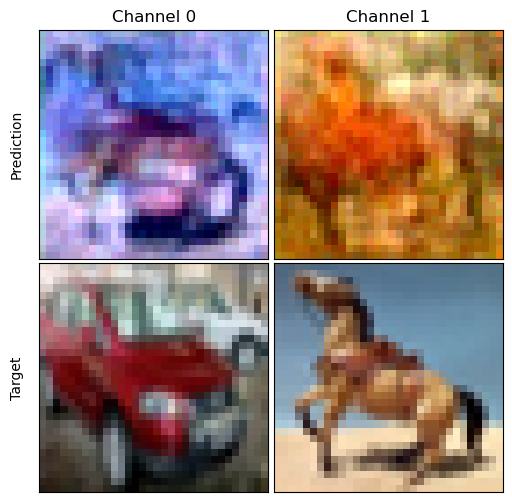

In [49]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
pred_tmp = pred_unnorm if len(pred_unnorm.shape) == 3 else pred_unnorm[-1]
target_tmp = target_unnorm[0]
rgb_ch = target_tmp.shape[-1]

_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
ax[0,0].set_ylabel('Prediction')
ax[1,0].set_ylabel('Target')
ax[0,0].set_title('Channel 0')
ax[0,1].set_title('Channel 1')
ax[0,0].imshow(pred_tmp[...,:rgb_ch//2])
ax[1,0].imshow(target_tmp[...,:rgb_ch//2])

ax[0,1].imshow(pred_tmp[...,rgb_ch//2:])
ax[1,1].imshow(target_tmp[...,rgb_ch//2:])
clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)

In [50]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [51]:
# diffusion.netG

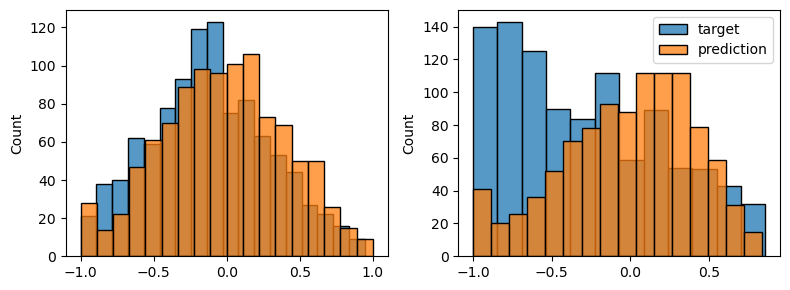

In [52]:
import seaborn as sns
_,ax = plt.subplots(figsize=(8,3),ncols=2)
for ch_idx in range(2):
    sns.histplot(target[0,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
    sns.histplot(prediction[-1,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
plt.legend()
plt.tight_layout()